# Differentiable Physics I:  Verlet Integration

## Forward Integration of Newton's Equations of Motion

Given a particle with:

- position $x$ 
- mass $m$ 
- velocity $v$ = $\frac{dx}{dt}$ 
- acceleration $a$ = $\frac{dv}{dt}$ = $\frac{d^2x}{dt^2}$
- force $F$ 

For a simple example, we apply the second motion $ F = m \frac{d^2 x}{dt^2} $ along with Hooke's Law $F(x) = -k x$. This results in the following differential equation:

$$ m a = -k x \\
\frac{d^2x}{dt^2} = \frac{-k}{m} x$$

In order to solve such an ODE numerically, we discretize the time $t$ into steps $\Delta t$. Therefore we add a time index $i$ to the variables $x$, $v$ and $a$:

$$ x_i = x(t_i) \\
v_i = v(t_i) \\
a_i = a(t_i) $$

$$ \Delta t = t_{i+1} - t_i $$


We can use the taylor expansion to approximate the positions:

$$ x_{i+1} = x_i + \Delta t \frac{dx}{dt} + \frac{\Delta t^2}{2} \frac{d^2x}{dt^2} + \mathcal{O}(\Delta t^3) $$

And the velocities:

$$ v_{i+1} = v_i + \Delta t \frac{dv}{dt} + \mathcal{O}(\Delta t^2) $$

This taylor series builds the foundation for many numerical integrators such as the Euler method, the Runge-Kutta method or the Leapfrog method.

In this notebook we focus on the velocity verlet method:

$$ x_{i+1} = x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2 \\
v_{i+1} = v_i + \frac{1}{2} (a_i + a_{i+1}) \Delta t $$

## Differentiable Physics

In order to make the integration of the equations of motion differentiable, we need to find the gradient of the solver with respect to its input. Lets denote the state of system at point $i$ as $s_i = (x_i, v_i)$. The solver $P$ is a function that takes the state $s_i$ and returns the state $s_{i+1}$:

$$ s_{i+1} = P(s_i) $$

which allows us to find the state of the system at any point in time with an initial state $s_0$:

$$ s_{n} = P_n \circ P_{n-1} \circ \dots \circ P_1(s_0) $$



A common task is given a desired enstate $s^*_n$ find $s_0$ such that $||s_n - s^*_n||^2$ is minimal. In theory we could simply use the inverse of the solver $P^{-1}$ to find $s_0$:

$$ s_0 = P^{-1}_1 \circ P^{-1}_2 \circ \dots \circ P^{-1}_n(s^*_n) $$

In practice however, this is oftentimes not possible since inverting the solver $P$ can come at great costs or its not even possible. **Why not?**

However we can *always* find the gradient of the solver $P$ with respect to its input:

$$\frac{\partial P}{\partial s_i} $$

This can become useful to propate the loss with respect to $s_0$, which is defined as:

$$ L = || \left( P_n \circ P_{n-1} \circ \dots \circ P_1(s_0) \right) - s^*_n ||^2 $$

backwards through the solvers:

$$ \frac{\partial L}{\partial s_0} = \frac{\partial L}{\partial s_n} \frac{\partial s_n}{\partial s_{n-1}} \dots \frac{\partial s_1}{\partial s_0} = \frac{\partial L}{\partial s_n} \frac{\partial P_n}{\partial s_{n-1}} \dots \frac{\partial P_1}{\partial s_0} $$

Now the problem has been transformed into an optimization problem, where we can use gradient descent to iteratively improve $s_0$:

$$ s_0 = s_0 - \alpha \frac{\partial L}{\partial s_0} $$

where $\alpha$ is the learning rate and $s_0$ can be set to all zeros initially.


## Differentiable Newtons Equations

Let us now apply the principle of differentiable physics to the equations of motion. We start with the forward integration of the equations of motion:

$$ x_{i+1} = x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2 \\ 
v_{i+1} = v_i + \frac{1}{2} (a_i + a_{i+1}) \Delta t $$

Let us assume we have force which is only dependent on the position $F(x_i)$. The integration scheme can also be written as:

$$ \begin{bmatrix} x_{i+1} \\ v_{i+1} \end{bmatrix} = \begin{bmatrix} x_i \\ v_i \end{bmatrix} + \Delta t \begin{bmatrix} v_i \\ 0.5 \times (a_i + a_{i+1})\end{bmatrix} + \frac{\Delta t^2}{2} \begin{bmatrix} a_i \\ 0 \end{bmatrix} $$

We can express the numerical solver as function $P$ which takes the state $s_i$ or $\begin{bmatrix} x_{i} \\ v_{i} \end{bmatrix}$ and returns the state $s_{i+1}$:

$$ \begin{bmatrix} x_{i+1} \\ v_{i+1} \end{bmatrix} = P \left( \begin{bmatrix} x_{i} \\ v_{i} \end{bmatrix} \right) = \begin{bmatrix} x_i \\ v_i \end{bmatrix} + \Delta t \begin{bmatrix} v_i \\ 0.5 \times (a_i + a_{i+1})\end{bmatrix} + \frac{\Delta t^2}{2}\begin{bmatrix} a_i \\ 0 \end{bmatrix} $$


We can now find the gradient of the solver $P$ with respect to its input $s_i$:

$$ \frac{\partial P(s_i)}{\partial s_i} = \begin{bmatrix} \frac{\partial P(s_i)}{\partial x_i} & \frac{\partial P(s_i)}{\partial v_i} \end{bmatrix}

= \begin{bmatrix} 1 + \frac{\Delta t ^2}{2m} \frac{\partial F(x_i)}{\partial x_i } & \Delta t 
\\ \frac{\Delta t}{2m} \left( \frac{\partial F(x_i)}{\partial x_i}  + \frac{\partial F(x_{i+1})}{\partial x_{i}} \right) & 1 \end{bmatrix}$$

Let us now program this in python. 

## Python Implementation

### Verlet Solver

We implement the backward and forward integration of the verlet solver in python:


In [100]:
import numpy as np
from typing import Callable

class Verlet: 

    def __init__(self, F : Callable, dFdx : Callable) -> None:
        self.F = F
        self.dFdx = dFdx

    def forward(self, x : np.ndarray, v : np.ndarray, dt : float, m : float) -> tuple[np.ndarray, np.ndarray]:
        dt2 = dt * dt
        x_fwd = x + v * dt + 0.5 * self.F(x) / m * dt2
        v_fwd = v + 0.5 * (self.F(x) + self.F(x_fwd)) * dt / m

        # cache for backward pass
        self.cache_x = x
        self.cache_v = v
        self.cache_x_fwd = x_fwd
        self.m = m
        self.dt = dt

        return x_fwd, v_fwd
    
    def backward(self, grad_x : np.ndarray, grad_v : np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        dt2 = self.dt * self.dt / 2
        dt1 = self.dt / 2 
        grad_x = (1 + dt2 / self.m * self.dFdx(self.cache_x)) * grad_x + dt1 * grad_v
        grad_v = (dt1 / self.m * (self.dFdx(self.cache_x) + self.dFdx(self.cache_x_fwd))) * grad_v + grad_v
        
        return grad_x, grad_v




A simple simulation loop computes the trajectory of a particle under the influence of a force field. 

In [101]:
def simulate(x0 : np.ndarray, v0 : np.ndarray, F : Callable, dFdx : Callable, n : int, dt : float):
    x = x0
    v = v0

    m = 1
    P_cache = []

    for i in range(n):
        P = Verlet(F, dFdx)
        x, v = P.forward(x, v, dt, m)
        P_cache.append(P)

    return x, v, P_cache

### Forward Integration

We define some helpers function for plotting and collecting the data.

In [109]:
import matplotlib.pyplot as plt

def get_timeline(P_cache : list[Verlet]) -> np.ndarray:
    xs = np.zeros((len(P_cache), 2))
    vs = np.zeros((len(P_cache), 2))
    t = np.zeros(len(P_cache))
    for i in range(len(P_cache)):
        xs[i,:] = P_cache[i].cache_x
        vs[i,:] = P_cache[i].cache_v
        t[i] = i
    return xs, vs, t

def display(P_cache : list[Verlet], title : str):
    fig, ax = plt.subplots(figsize=(6,5))

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    xs, _, t = get_timeline(P_cache)

    scatter = ax.scatter(xs[:,0], xs[:,1], cmap="Reds", c=t, s=5, marker="o")
            
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("iteration")

We show the trajectory of the particle with a force field $F(x) = -x$.

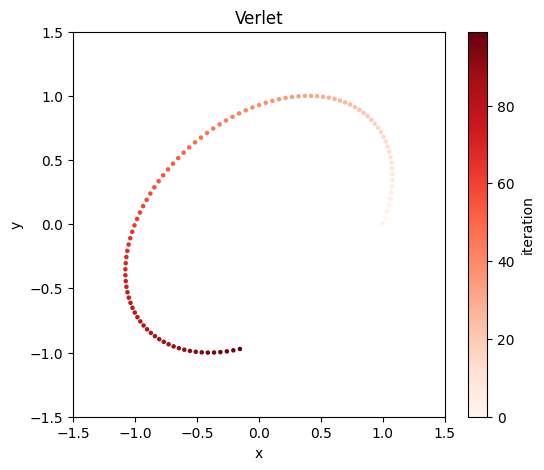

In [110]:
# Define a force 
F = lambda x : -x
dFdx = lambda x : -1

# initial position and velocity
x0 = np.array([1, 0])
v0 = np.array([0.4, 1])

x, v, P_cache = simulate(x0, v0, F, dFdx, 100, 0.05)

display(P_cache, "Verlet")

### Inverse Problem

Let us now try to solve the inverse problem of finding the initial state $s_0$ given a desired endstate $s^*_n$:

In [111]:
# Define a force 
F = lambda x : -x
dFdx = lambda x : -1

# Make a guess for initial position and velocity
x0_guess = np.array([0, -0.5], dtype=np.float32)
v0_guess = np.array([1, 0], dtype=np.float32)

xn_star = np.array([1, 1], dtype=np.float32)
vn_star = np.array([0, 1], dtype=np.float32)

n_iterations = 100
dt = 0.03


A visual inspection of the setup shows how the trajectory of the initial state $s_0$ is far away from the desired endstate $s^*_n$ when simulated forward in time.

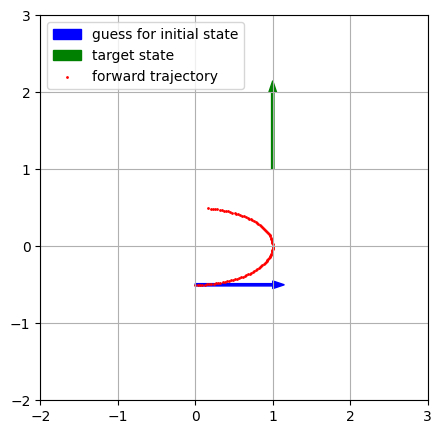

In [112]:
x, v, P_cache = simulate(x0_guess, v0_guess, F, dFdx, n_iterations, 0.03)

plt.figure(figsize=(5,5))
plt.grid()

plt.xlim(-2, 3)
plt.ylim(-2, 3)

plt.arrow(x0_guess[0], x0_guess[1], v0_guess[0], v0_guess[1], color="blue", width=0.03, head_width=0.1)
plt.arrow(xn_star[0], xn_star[1], vn_star[0], vn_star[1], color="green", width=0.03, head_width=0.1)

xs, _, t = get_timeline(P_cache)
plt.scatter(xs[:,0], xs[:,1], c="red", s=1, marker="o")

plt.legend(["guess for initial state", "target state", "forward trajectory"])

To quantify the distance between the simulated endstate and the desired endstate we use the squared distance as loss function. Using the loss we have all the ingredients to compute the gradient of the loss with respect to the initial state $s_0$. This allows us to use gradient descent to iteratively improve the initial state $s_0$.

In [113]:
class Loss:
    def __init__(self, truth : np.ndarray) -> None:
        self.truth = truth.copy()

    def forward(self, x : np.ndarray) -> float:
        self.cache_x = x.copy()
        return np.linalg.norm(x - self.truth)
    
    def backward(self, grad : float) -> np.ndarray:
        return grad * (self.cache_x - self.truth) / np.linalg.norm(self.cache_x - self.truth)

Text(0, 0.5, 'loss')

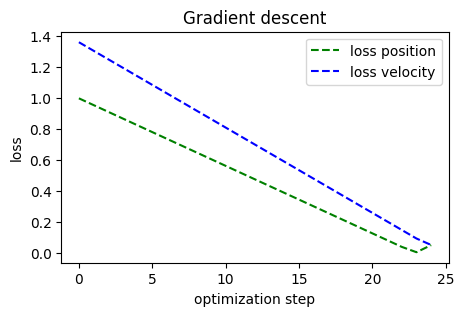

In [114]:

x0 = x0_guess.copy()
v0 = v0_guess.copy()

learning_rate = 0.05
optimization_steps = 25

trajectories = np.zeros((optimization_steps, n_iterations, 2))
velocities = np.zeros((optimization_steps, n_iterations, 2))

losses_x = np.zeros(optimization_steps)
losses_v = np.zeros(optimization_steps)

for i in range(optimization_steps):
    
    xn, vn, P_cache = simulate(x0, v0, F, dFdx, n_iterations, dt)
    
    xs, vs, t = get_timeline(P_cache)
    trajectories[i,:,:] = xs
    velocities[i,:,:] = vs

    loss_x = Loss(xn_star)
    loss_v = Loss(vn_star)

    lx = loss_x.forward(xn)
    lv = loss_v.forward(vn)

    losses_x[i] = lx
    losses_v[i] = lv

    grad_lx = loss_x.backward(1)
    grad_lv = loss_v.backward(1)
    for P in reversed(P_cache):
        grad_x, grad_v = P.backward(grad_lx, grad_lv)

    x0 += learning_rate * grad_x
    v0 += learning_rate * grad_v

plt.figure(figsize=(5,3))

plt.plot(losses_x, label="loss position", color="green", linestyle="dashed")
plt.plot(losses_v, label="loss velocity", color="blue", linestyle="dashed")

plt.legend()

plt.title("Gradient descent")
plt.xlabel("optimization step")
plt.ylabel("loss")


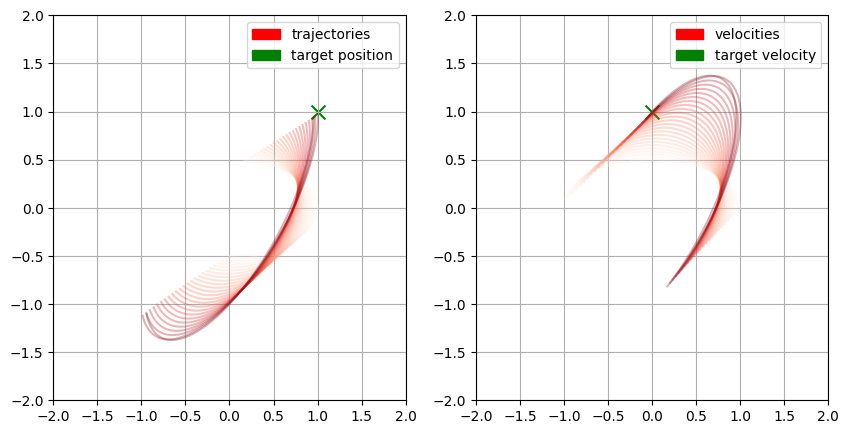

In [120]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
cmap = plt.get_cmap("Reds")

# Plot the trajectories
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-2, 2)
axs[0].grid()

axs[0].scatter(xn_star[0], xn_star[1], c="green", s=100, marker="x")    

red_patch = mpatches.Patch(color='red', label='trajectories')
green_patch = mpatches.Patch(color='green', label='target position')

handles = [red_patch, green_patch]
for i in range(optimization_steps):
    axs[0].plot(trajectories[i,:,0], trajectories[i,:,1], alpha=0.3, color=cmap(i/optimization_steps))
axs[0].legend(handles=handles)

# Plot the velocities
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-2, 2)
axs[1].grid()

axs[1].scatter(vn_star[0], vn_star[1], c="green", s=100, marker="x")

red_patch = mpatches.Patch(color='red', label='velocities')
green_patch = mpatches.Patch(color='green', label='target velocity')
handles = [red_patch, green_patch]

for i in range(optimization_steps):
    axs[1].plot(velocities[i,:,0], velocities[i,:,1], alpha=0.3, color=cmap(i/optimization_steps))
axs[1].legend(handles=handles)
